# Kræsjkurs i AI - Grunnleggende prinsipper

## Kunstig intelligens er så mangt
<img src="https://media.licdn.com/dms/image/D5612AQE4PAb7ReqhRg/article-cover_image-shrink_600_2000/0/1679715986172?e=2147483647&v=beta&t=LlQEO0Tf583irseJlj3G3BI2pvpJaLyGM_gxALuwB0E">

Venn-diagrammet viser at tre buzzwords vi er kjent med i dagligtalen faller inn under hverandre.
- AI
    - Ethvert system som utfører en oppgave hvor menneskelig intelligens kreves faller under begrepet AI.
    - Eksempler
        - Søkealgoritmer som A*
        - Ekspertsystemer / regel-baserte systemer
            - Består av regler som er lagd av mennesker
        - Alt som faller inn under maskinlæring
- Maskinlæring
    - Et system/algoritme som bygger opp en form for kunnskap basert på data. Denne kunnskapen brukes så til å løse problemer. 
    - Implementasjonen består av to faser 
        - Trening
        - Bruk av modellen (også kalt inference)
    - Eksempler
        - Beslutningstrær
            - <img src="https://images.datacamp.com/image/upload/v1677504957/decision_tree_for_heart_attack_prevention_2140bd762d.png" height="300px">
            Reglene konstrueres ved hjelp av en treningsalgoritme
        - Alt som faller inn under dyp læring
- Dyp læring
    - Et system som bygger opp en form for kunnskap basert på data ved bruk av nevrale nettverk.
    - Jobber på vektorer med numeriske verdier, og beregninger utføres vanligvis på GPUer.
    - Eksempler
        - Blir gjennomgått i kodebiten av denne notebooken.

Det finnes en annen inndelig av AI som også brukes ofte:
- Symbolsk AI
    - AI hvor beslutningene skjer på grunnlag av regler som kan deles opp i _symboler_. 
    - Synonym med GOFAI (Good-Old Fashioned AI)
    - Eksempler
        - Regler som spesifiseres ved hjelp av et programmeringsspråk, altså en algoritme.
- Subsymbolsk AI
    - AI hvor beslutningene skjer på grunnlag av regler som ikke kan direkte tolkes av mennesker
    - Er mer matematisk jordet. 
    - Eksklusivt dyp læring, altså bare den innerste gruppen i venn-diagrammet.

    
## Dyp læring

Venn-diagrammet er litt utdatert. Under _Deep Learning_ mangler det feks:
- Transformers
    - En arkitektur hovedsaklig for språkforståelse vi **garantert** kommer til å ta i bruk.
- Diffusjonsmodeller
    - En modell som de siste to årene har oppnåd bedre resultater enn Generative Adversarial Networks (GAN). Brukes for det meste på bildesyntese.

- Hvorfor bryr vi oss mest om dyp læring nå (både i dette kurset og til daglig)?
    - Flesteparten av modellene som imponerer oss består av dype nevrale nettverk.
        - ChatGPT
        - GPT-4
        - Stable Diffusion
        - Midjourney
        - AlphaZero
    - Tekniske ressurser er tilgjengelige for å realisere mye av teorien som ble funnet på 50-tallet.

## Former for maskinlæring
- Supervised learning
    - Man bruker data og beskrivelser av dataen til å trene opp en modell.
- Unsupervised learning
    - Man bruker bare selve dataen, og modellen finner mønstre som man etterpå kan studere.
- Reinforcement learning
    - Man plasserer en modell i et miljø som den får utforske og samle inn data selv.


# Den tekniske biten - Hvordan ser det ut å jobbe med nevrale nettverk nå til dags?
Det er flere begreper innen maskinlæring som kastes rundt i diskusjoner. Ved å gå gjennom denne delen vil man kunne se tydeligere hva som menes med begrepene. 

Instrukser for å kjøre kodeceller:
- VSCode og Google Colab
    - Velg en celle og trykk på ▶️-knappen til venstre av cellen
- Jupyter Notebook i nettleseren
    - Velg en celle og trykk på ▶️-knappen i navigasjonsmenyen i toppen av vinduet. 
- Shortcut for alle nevnt over
    - Velg en celle og trykk `CTRL-Enter`



## Vektorer
I maskinlæring er all data i form av vektorer.

Vi begynner med Numpy, som er det mest brukte biblioteket for data science i Python. Biblioteket tilbyr kraftigere metoder for å håndtere native Python-lister.

In [296]:
import numpy as np

## Dimensjoner og _shapes_
Fra matematikken vet vi at en liste med feks. 3 tall definerer en vektor/punkt som lever i et tre-dimensjonalt rom. Dette ser slikt ut i Numpy:

In [297]:
data = [3, 2, 1] # Starting with a normal python list
vector = np.array(data) # Creating a numpy array from it
vector

array([3, 2, 1])

Med Numpy-arrays er det flere operasjoner som kan gjøres (som vi også til en grad vil forvente av native Python-arrays).

In [298]:
print(f"Max value: {vector.max()}")
print(f"Min value: {vector.min()}")

print(f"Index of max element: {vector.argmax()}")
print(f"Index of min element: {vector.argmin()}")

print(f"Sum: {vector.sum()}")

print(f"Sorted:  {np.sort(vector)}")

Max value: 3
Min value: 1
Index of max element: 0
Index of max element: 2
Sum: 6
Sorted:  [1 2 3]


På lik linje har vi et 16-dimensjonalt punkt (som vi heller lager med tilfeldige tall):

In [299]:
high_dim_vector = np.random.randint(low=1, high=10, size=(16))
high_dim_vector

array([1, 5, 3, 3, 5, 6, 5, 5, 7, 3, 8, 9, 2, 2, 7, 1])

Matematikken sier videre at en matrise er en rektangulær liste / tabell. For matriser definerer man antall rader og kolonner. Det er her Numpy begynner å divergere litt fra vanlige Python-arrays. 

Vi lager en $2 \times 3$-matrise, altså med 2 rader og 3 kolonner. 

In [300]:
matrix = np.random.randint(low=1, high=10, size=(2, 3))
matrix

array([[4, 6, 9],
       [2, 8, 6]])

Er vi usikker på hvilken _shape_ matrisen har, kan vi sjekke det med `.shape` attributtet.

In [301]:
print(f"The shape of the matrix is {matrix.shape}")
rows, cols = matrix.shape
print(f"It has {rows} rows and {cols} columns")

The shape of the matrix is (2, 3)
It has 2 rows and 3 columns


Vi kan gå videre ved å legge til dybde på en matrise, og lage det som kalles en tensor

In [302]:
tensor = np.random.randint(low=0, high=10, size=(2, 3, 4))
print(f"The shape of the tensor is {tensor.shape}")
tensor

The shape of the tensor is (2, 3, 4)


array([[[2, 3, 0, 7],
        [1, 0, 4, 9],
        [7, 2, 7, 0]],

       [[9, 2, 1, 9],
        [5, 9, 0, 3],
        [0, 0, 2, 4]]])

Tensoren over består av 2 matriser som hver har 3 rader og 4 kolonner.

Min faglige erfaring tilsier at særlig begrepene _vektor_ og _tensor_ er generelle, og beskriver bare en samling verdier strukturert med en vilkårlig _shape_. Rent praktisk er de flerdimensjonale lister/arrays. I denne gjennomgangen vil begge begrepene brukes litt her og der.

Her kommer det derfor et veiskille i hva man legger i begrepet _dimensjoner_ når man referer til en tensor:
- Antall elementer til sammen i tensoren (matematisk riktig)
- Antall elementer som ligger i resultatet av `.shape`-attributtet 

For å redusere forvirring kaller man ofte den første for antall _features_. Den andre kan vi kalle for shape-dimensjoner. 

Numpy-arrays er veldig fleksible:

In [303]:
reshaped = tensor.reshape(2, 3*4) # Combine the rows and columns into one
print(f"Shape of the reshaped tensor: {reshaped.shape}")
reshaped

Shape of the reshaped tensor: (2, 12)


array([[2, 3, 0, 7, 1, 0, 4, 9, 7, 2, 7, 0],
       [9, 2, 1, 9, 5, 9, 0, 3, 0, 0, 2, 4]])

Hvis det er en shape-dimensjon vi ikke har styr på og ofte varierer kan vi la Numpy regne det ut selv ved å spesifisere `-1` for **en** av posisjonene.

Dette er veldig nyttig når vi ønsker å samle flere datapunkt i en tensor. Vi vet gjerne hvordan et datapunkt ser ut, feks et bilde vil ha en bestemt høyde og bredde og antall fargekanaler. Og disse verdiene vil være felles for alle datapunkt i datasettet. Denne prosessen kalles for batching, og vi kommer tilbake til det senere. 

In [304]:
reshaped = tensor.reshape(-1, 3*4)
reshaped

array([[2, 3, 0, 7, 1, 0, 4, 9, 7, 2, 7, 0],
       [9, 2, 1, 9, 5, 9, 0, 3, 0, 0, 2, 4]])

Når vi har flere _shape_-dimensjoner har vi muligheten til å spesifisere dimensjoner av interesse for noen av operasjonene.

In [308]:
tensor = np.random.randint(low=0, high=10, size=(2, 3))
tensor

array([[3, 3, 6],
       [4, 4, 2]])

In [306]:
print(f"Summing along rows: {tensor.sum(axis=0)}")
print(f"Summing along columns: {tensor.sum(axis=1)}")

Summing along rows: [11  5 17]
Summing along columns: [15 18]


In [310]:
print(f"Min values along rows: {tensor.min(axis=1)}")

Min values along rows: [3 2]


## Rammeverket PyTorch

PyTorch er et av flere biblioteker som brukes til trening av dype nevrale nettverk. Det andre kjente alternativet er TensorFlow. Hva man velger avhenger mye av smak, men begge har sine fordeler og ulemper. Jeg liker PyTorch fordi mindre av treningsprosessen blir gjemt og man har mer frihet.
PyTorch omfatter mye av den funksjonaliteten man finner i Numpy, men tilbyr metoder for trening og konstruksjon av nevrale nettverk. En `np.ndarray` er ekvivalent med en `torch.Tensor`. Derfor tar vi nå med oss det vi har lært om Numpy-arrays når vi studerer Pytorch-tensorer. 

In [311]:
import torch

In [312]:
tensor = torch.rand(2, 2)
print(tensor)
print(f"Tensor shape: {tensor.shape}")

tensor([[0.1936, 0.0165],
        [0.8722, 0.7842]])
Tensor shape: torch.Size([2, 2])


Det er to viktige funksjonaliteter `torch.Tensor` implementerer, som man ikke finner i Numpy-arrays:
1. Støtte for å flytte dataene mellom CPU og GPU (hvis installert på datamaskinen).
2. Loggføring av hvilke operasjoner som er gjort på tensoren (nyttiggjøres under trening)

Vi ser på det første punktet ved å lage en tensor og sjekke hvilken enhet den havner på.

In [313]:
print(f"Default tensor location: {tensor.device}")

Default tensor location: cpu


In [314]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [318]:
tensor = tensor.to(device)

Det andre punktet er loggføring av operasjoner på tensorer. Dette skjer bare på tensorer hvor flagget `requires_grad` er aktivert, og tensorer som deltar i en operasjon med en annen tensor som har det aktivert.

In [320]:
tensor = torch.rand(2, 2, requires_grad=True)
tensor

tensor([[0.3079, 0.0778],
        [0.8382, 0.7813]], requires_grad=True)

In [321]:
tensor = tensor + 2
tensor

tensor([[2.3079, 2.0778],
        [2.8382, 2.7813]], grad_fn=<AddBackward0>)

In [322]:
tensor = tensor * 10
tensor

tensor([[23.0790, 20.7781],
        [28.3816, 27.8133]], grad_fn=<MulBackward0>)

In [323]:
tensor = tensor / 10
tensor

tensor([[2.3079, 2.0778],
        [2.8382, 2.7813]], grad_fn=<DivBackward0>)

Vi kan sjekke loggen for å se at operasjonene er dokumentert. 

**Merk**: Dette gjør vi for moro skyld. Det er ikke noe man gjør i praksis.

In [324]:
grad_fn = tensor.grad_fn
while len(grad_fn.next_functions) != 0:
    print(grad_fn)
    grad_fn = grad_fn.next_functions[0][0]


## Oppsett av nevrale nettverk med PyTorch
Nevrale nettverk har vanligvis komplekse strukturer. Likevel består de av flere isolerte komponenter, og disse finner man i `torch.nn`. 

De fleste komponentene blir et såkalt _lag_ i nettverket, mens andre komponenter anvendes på eksisterende lag (feks aktiveringsfunksjoner). 

Den enkleste er `torch.nn.Linear`, og setter opp et lineært lag. Matematisk gjør den en lineær transformasjon fra et vektorrom til et annet. Feks kan den ta inn en vektor med 5 features, og outputte en vektor med 3 features:

<img src="nn_5in_3out-cropped.svg" width="500px" height="auto" alt="SVG Image"  style="filter: invert(100%); "/>




In [325]:
import torch.nn as nn
layer = nn.Linear(in_features=5, out_features=3) # Construct layer
layer

Linear(in_features=5, out_features=3, bias=True)

In [326]:
data = torch.Tensor([[1, 2, 3, 4, 5]])
print(f"Input vector: {data}")
output = layer(data) # Feed data into layer
print(f"Output vector: {output}")

Input vector: tensor([[1., 2., 3., 4., 5.]])
Output vector: tensor([[ 0.1784,  0.2906, -4.6836]], grad_fn=<AddmmBackward0>)


In [327]:
print(layer.weight)
print(f"Weight shape: {layer.weight.shape}\n")

print(layer.bias)
print(f"Bias shape: {layer.bias.shape}")

Parameter containing:
tensor([[ 0.3408, -0.0822, -0.1426,  0.0934,  0.0756],
        [-0.1395, -0.1238,  0.1479,  0.3747, -0.2335],
        [-0.2513, -0.3310, -0.1898, -0.3191, -0.3226]], requires_grad=True)
Weight shape: torch.Size([3, 5])

Parameter containing:
tensor([-0.3214, -0.0970, -0.3116], requires_grad=True)
Bias shape: torch.Size([3])


Når man sender input-vektoren inn skjer følgende operasjon (hvor `@` er matrisemultiplikasjon):

In [328]:
data @ layer.weight.T + layer.bias

tensor([[ 0.1784,  0.2906, -4.6836]], grad_fn=<AddBackward0>)

Vi ser fra resultatet over at det stemmer .


Vektene og biaset utgjør til sammen **parametrene** for dette lineære laget, og er verdiene som endres under trening. Hvordan disse er strukturert og brukes varierer for andre typer lag. Konvolusjonelle lag bruker en "sliding window"-mekanisme hvor de samme vektene multipliseres med forskjellige deler av et bilde. Da brukes vanligvis et mindre antall parametre. Til denne introduksjon holder vi oss derimot til lineære lag. 

### Aktiveringsfunksjoner

Det lineære laget utfører en lineær operasjon. Fleksibiliteten av nevrale nettverk kommer derimot av såkalte _aktiveringsfunksjoner_ som utfører ikke-lineære operasjoner på data. Disse inneholder **vanligvis ikke** trenbare parametre. De enkleste opererer på hvert element individuelt, som feks Tanh. Vi ser på et en-dimensjonalt-case for å visualisere det enkelt.

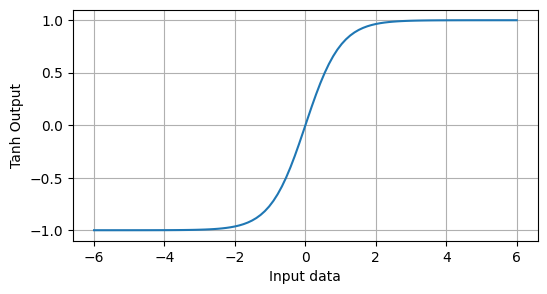

In [329]:
import matplotlib.pyplot as plt # Library for visualization
tanh = nn.Tanh()
assert not hasattr(tanh, "weight") # No learnable weights

data = torch.linspace(start=-6, end=6, steps=100) # One-dimensional vector with 100 elements 
output = tanh(data)

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(data, output)
ax.set_xlabel("Input data")
ax.set_ylabel("Tanh Output")

# Add a grid
ax.grid(True)

Et viktig poeng er at aktiveringsfunksjoner ikke modifiserer _shapen_ til tensoren. Dette kan demonstreres på en tensor med flere shape-dimensjoner. 

In [330]:
data = torch.rand(30, 5, 15)
print(f"shape before activation function: {data.shape}")
data = tanh(data)
shape2 = print(f"shape after activation function: {data.shape}")

shape before activation function: torch.Size([30, 5, 15])
shape after activation function: torch.Size([30, 5, 15])


En annen viktig er `nn.Softmax`, og brukes til å transformere en vektor til elementer som summeres til 1. 

Dette gjør den litt annerledes enn Tanh, siden vi må spesifisere en av shape-dimensjonene som skal summeres til 1.

Passer fint som siste lag i et nettverk man ønsker skal modellere en sannsynlighetsfordeling (Total sannsynlighet av alle utfallene av en stokastisk variabel skal være 1). Derfor er den veldig relevant for NLP, siden de fleste språkmodeller lærer seg en betinget sannsynlighetsfordeling over ord gitt tidligere tekst. 

For denne anledningen tar vi også i bruk `nn.functional`, som er et delbibliotek som tilbyr mange av komponentene tilstandsfrie. 

In [331]:
import torch.nn.functional as F

# data = torch.Tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
data = torch.randn(3, 3)
print(f"Original data:\n{data}")
data = F.softmax(data, dim=1)
print(f"Transformed data:\n{data}")
print(f"Summing individual batch elements:\n{data.sum(dim=1)}")

Original data:
tensor([[-1.2081,  0.7485, -0.2713],
        [ 0.3803, -0.2198,  0.0969],
        [-0.0125, -0.8866, -0.0256]])
Transformed data:
tensor([[0.0941, 0.6658, 0.2401],
        [0.4344, 0.2384, 0.3272],
        [0.4159, 0.1735, 0.4105]])
Summing individual batch elements:
tensor([1.0000, 1.0000, 1.0000])


## Klassifisering av sifre
Vi skal sette opp et nevralt nettverk som er i stand til å klassifisere sifre. Til det trenger vi det lett tilgjengelige MNIST-datasettet. Dette lastes ned gjennom torchvision-biblioteket. Torchvision-biblioteket er et hjelpebibliotek som tilbyr verktøy for Computer Vision-oppgaver. 

Datasett kommer vanligvis i et rå-format, og må behandles for å tilpasse det oppgaven vi skal gjøre. I dette tilfellet får vi PNG-bilder som må gjøres om til tensorer. Vi normaliserer også bildene for å få [bedre resultater](https://developers.google.com/machine-learning/data-prep/transform/normalization). Behandlingen gjøres med `torchvision.transforms`-biblioteket. 

In [334]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

# Pipeline of processing operations
image_processing = transforms.Compose([
    transforms.ToTensor(), # Cast into torch.Tensor
    transforms.Normalize((0.5,), (0.5,)) # Pixel-values will range in [-1, 1]
])

train_dataset = MNIST(root='./data', train=True, transform=image_processing, download=True)
test_dataset = MNIST(root='./data', train=False, transform=image_processing, download=True) # Test data for later

I maskinlæring trener man flere epoker (iterasjoner) på samme datasettet. 

Hver epoke inneholder igjen flere iterasjoner som består av å oppdatere vektene på et lite subset av datasettet. Man kaller dette for en batch. Denne logikken oppnår vi delvis gjennom `torch.utils.data.DataLoader`. Resten kommer når selve treningen skjer. 

In [335]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32) # Iterable that provides 16 data samples each iteration

data, labels = next(iter(train_loader)) # Retrieve a batch of data samples and labels for inspection purposes
print(f"Shape of data batch: {data.shape}")


Shape of data batch: torch.Size([32, 1, 28, 28])


Tensoren inneholder 32 eksemplarer, 1 fargekanal (grayscale), 28 piksler i høyden, og 28 piksler i bredden.
Vi kan visualisere et tilfeldig eksemplar fra hele datasettet.

Shown below is the digit 6


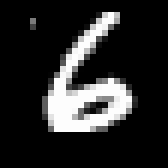

In [339]:
# Creating a function to easily visualize MNIST instances
def visualize(tensor):
    h, w = tensor.shape[-2:]
    image = transforms.functional.resize((tensor+1)/2, (h*6, w*6), interpolation=transforms.InterpolationMode.NEAREST) # Upscaling for visual purposes
    image = transforms.functional.to_pil_image(image)
    return image

import random
rand_index = random.randint(0, len(train_dataset)-1)
data_sample, label_sample = train_dataset[rand_index]

print(f"Shown below is the digit {label_sample}")
visualize(data_sample)

Og tensoren i seg selv ser slik ut:

In [342]:
data_sample

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -0.7804,  0.6000,  1.0000,  0.5059, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.0353, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

### Vi trenger et nettverk
Alle lag i PyTorch arver fra `nn.Module`. Fra [dokumentasjonen](https://pytorch.org/docs/stable/generated/torch.nn.Module.html):

>Base class for all neural network modules. 
>
>Your models should also subclass this class.
>
>Modules can also contain other Modules, allowing to nest them in a tree structure.

Trestrukturen som snakkes om er veldig nyttig. Endringer vi gjør på toppen av treet vil propageres ned til enkeltmodulene. Feks det å flytte parametrene over på en annen device.

Vi husker det enkle lineære laget og tanh-funksjonen. De arver nemlig fra `nn.Module`.

In [343]:
print(layer.__class__.__base__)
print(tanh.__class__.__base__)

<class 'torch.nn.modules.module.Module'>
<class 'torch.nn.modules.module.Module'>


In [346]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=1*28*28, out_features=200) # Input features are the number of pixels, output features is arbitrary
        self.layer2 = nn.Linear(in_features=200, out_features=42) # Arbitrary values
        self.layer3 = nn.Linear(in_features=42, out_features=10) # 10 digits to differentiate between

        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1) # Softmax will be computed for each batch element separately 

    def logits(self, data):
        flattened_data = torch.flatten(data, start_dim=1, end_dim=-1) # Flatten the tensor from shape (batch_size, 1, 28, 28) to shape (batch_size, 1 * 28 * 28)

        out = self.layer1(flattened_data)
        out = self.tanh(out)

        out = self.layer2(out)
        out = self.tanh(out)

        out = self.layer3(out)
        return out
    
    def forward(self, data):
        logits = self.logits(data)
        return self.softmax(logits)
    
model = Model() # Initialize model
model.to(device)

Model(
  (layer1): Linear(in_features=784, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=42, bias=True)
  (layer3): Linear(in_features=42, out_features=10, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)

Modellen vår implementerer to metoder. `logits` gir unnormaliserte verdier og vil brukes under trening. `forward` bruker `softmax` til å normalisere output fra `logits`, og tas i bruk under _inference_.

Vi tester modellen på sifferet vi visualiserte tidligere. Men først må vi endre litt på _shapen_ til dette sifferet.

In [347]:
print(data_sample.shape)
test_input = data_sample[None, ...] # [None, ...] adds a new shape dimension in the front
print(test_input.shape)
test_input = test_input.to(device)

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


`data_sample[None, ...]` lager en kopi av `data_sample` med en ny dimensjon lagt til.
De fleste modulene i PyTorch forventer at input skal ha en batch-dimensjon, selv om batchen inneholder bare en instans (et bilde i dette tilfellet).

Kodesnutten er veldig kryptisk. 
- PyTorch tolker indeksering med typen `None` som at en ny shape-dimensjon skal lages. 
- De etterfølgende `...` samler de resterende shape-dimensjonene. Dette er det samme som `data_sample[None, :, :, :]`.
- `test_input` består av de nøyaktige samme elementene, men _organisert_ på en annen måte. 

En tilsvarende måte å skrive det på er `data_sample.unsqueeze(dim=X)`. Denne setter inn en ny (tom) dimensjon ved den spesifiserte dimensjonen. På samme måte kan man fjerne (tomme) dimensjoner med `data_sample.squeeze(dim=X)`.


In [348]:
out = model.forward(test_input)
print(out)
print(f"The untrained model predicts the digit to be {out.argmax()}")

tensor([[0.1210, 0.1021, 0.0943, 0.0995, 0.0950, 0.1094, 0.0863, 0.1152, 0.0980,
         0.0793]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
The untrained model predicts the digit to be 0


### Trening
Vi ser fra resultatene at modellen ikke er i stand til å avgjøre hvilket siffer inputten var. 

Vi har modellen og datasettet. Da er det to viktige ting som mangler for å kunne oppnå en fungerende modell. 
- **En loss-funksjon som definerer objectivet**
    - Vi ønsker at modellen skal gi høyest sannsynlighet på det rette sifret.
    
- **En algoritme som utfører gradient descent, altså selve maskinlæringen**
    - Denne algoritmen skal ta utgangspunkt i losset for å optimere parametrene.
    - Man implementerer slike aldri selv, og finner dem heller gjennom `torch.optim`.

#### Loss-funksjoner
Loss-funksjoner sammenlikner en prediction og et target. Prediction er output fra modellen, og target er fasiten vi vet fra datasettet. 
Den enkleste er _Mean Squared Error (MSE)_, som kalkulerer gjennomsnittlig kvadrert avvik mellom tilsvarende elementer i hver tensor.


In [353]:
a = torch.ones(size=(3, 4, 5))
b = torch.zeros(size=(3, 4, 5))
loss = F.mse_loss(a, b)
print(loss)

a = torch.rand(size=(3, 4, 5))
b = torch.rand(size=(3, 4, 5))
loss = F.mse_loss(a, b)
print(loss)

tensor(1.)
tensor(0.1711)


#### Gradient descent
Helt fram til beregningen av et loss konstrueres det en såkalt _computational graph_. Denne kan propageres bakover for å beregne gradienter (derav det kjente navnet [backpropagation](https://simple.wikipedia.org/wiki/Backpropagation) som brukes i alle nevrale nettverk idag).
- Fra matematikken vet vi at gradienter peker i retning hvor verdien øker mest i en flervariabel kurve. Beveger vi oss i motsatt retning vil verdien minske.
- Learning rate (en skalar verdi) styrer hvor store stegene er. 

Figuren under viser loss-funksjonen kalkulert for forskjellige verdier av parametrene $\theta_1$ og $\theta_2$ til en modell. 

[<img src="https://zitaoshen.rbind.io/project/optimization/1-min-of-machine-learning-gradient-decent/featured_hubf6ae7b9a0510d717632b017746fdfc1_374655_720x0_resize_lanczos_2.png">](https://zitaoshen.rbind.io/project/optimization/1-min-of-machine-learning-gradient-decent/)

<!-- Oppdatering av vektene gjøres da slikt:

$\boldsymbol{w} \leftarrow \underbrace{\alpha}_{\text{learning rate}}$ -->

Selv om konkrete regler finnes for beregning av gradientene til vektene, er det svært kronglete å gjøre manuelt. Derfor takker vi AI-gudene for bibliotek som PyTorch og Tensorflow som gjør denne prosessen så og si automatisk. 

#### Tilbake til treningen av en siffer-gjenkjenneren
Til loss-funksjonen bruker vi `nn.CrossEntropyLoss`. Den sammenlikner to sannsynlighetsfordelinger. Matematikken bak er ikke så viktig.

Til gradient descent bruker vi bruker Adam, som står for _Adaptive Moment Estimation_. Her er heller ikke matematikken viktig. 

In [355]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [356]:
from tqdm import tqdm # Progress bar

num_epochs = 3

for epoch in range(num_epochs):
    with tqdm(train_loader, unit="batch") as pbar:
        pbar.set_description(f"Epoch {epoch}")
        for i, (data, labels) in enumerate(pbar):
            data = data.to(device)
            labels = labels.to(device)
            pred = model.logits(data) # Query model for predictions
            loss = loss_fn(pred, labels)
            
            loss.backward() # Propagate the computational graph and calculate gradients
            optimizer.step() # Uses the calculated gradients on the registered parameters to perform an update
            optimizer.zero_grad() # Remove the gradients

            # pbar.set_postfix(loss=loss.cpu().item()) if i%40 == 0 else None
    

Epoch 2: 100%|██████████| 1875/1875 [00:08<00:00, 233.50batch/s]


### Testing av modellen

In [357]:
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=32)

correct = 0
for data, labels in test_loader:
    data = data.to(device)
    labels = labels.to(device)

    pred = model.forward(data)
    correct += torch.sum(pred.argmax(dim=1) == labels)
accuracy = correct/len(test_dataset)

print(f"The accuracy of the model on the test set is {accuracy}")

The accuracy of the model on the test set is 0.9544000029563904


In [ ]:
out = model.forward(test_input)
print(out)
print(f"The trained model predicts the digit to be {out.argmax()}")
# plt.bar(torch.linspace(0, 9, 10).numpy(), out[0].cpu().detach())

## AutoEncoder

For å komme litt inn i tankegangen om vektorrepresentasjoner av tekst (embeddings), ser vi på en arkitektur som kalles for AutoEncoder. 

<img src="autoencoder.png" height="300px">

Den består av to komponenter:
- Encoder
    - En sekvens med lineære lag som reduserer dimensjonaliteten.
    - Ender opp med en vektor med veldig få dimensjoner kontra 784 fra rådata.
- Decoder
    - En sekvens med lineære lag som rekonstruerer inputten fra den korte vektoren.

Vi tar i bruk `nn.Sequential` for å lage sekvenser av lag som dataen flyter gjennom.

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=200),
            nn.Tanh(),
            nn.Linear(in_features=200, out_features=42),
            nn.Tanh(),
            nn.Linear(in_features=42, out_features=16),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
             nn.Linear(in_features=16, out_features=42),
             nn.Tanh(),
             nn.Linear(in_features=42, out_features=200),
             nn.Tanh(),
             nn.Linear(200, 28*28),
             nn.Tanh()
        )

    def encode(self, data):
        out = torch.flatten(data, start_dim=1, end_dim=-1)
        out = self.encoder(out)
        return out
    
    def decode(self, data):
        out = self.decoder(data)
        return out.reshape(-1, 1, 28, 28)

    def forward(self, data):
        out = self.encode(data)
        out = self.decode(out)
        return out
    
autoencoder = AutoEncoder()
autoencoder.to(device)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 3

for epoch in range(num_epochs):
    with tqdm(train_loader, unit="batch") as pbar:
        pbar.set_description(f"Epoch {epoch}")
        for i, (data, _) in enumerate(pbar): # no need for labels
            data = data.to(device)
            pred = autoencoder.forward(data) # Query model for predictions
            loss = loss_fn(pred, data)
            
            loss.backward() # Propagate the computational graph and calculate gradients
            optimizer.step() # Uses the calculated gradients on the registered parameters to perform an update
            optimizer.zero_grad() # Remove the gradients

            pbar.set_postfix(loss=loss.cpu().item()) if i%40 == 0 else None

Vi studerer nå hvordan modellen klarer å rekonstruere et siffer fra datasettet.

In [ ]:
rand_index = random.randint(0, len(train_dataset)-1)
data_sample, label_sample = train_dataset[rand_index]

visualize(data_sample)

In [ ]:
encoding = autoencoder.encode(data_sample[None, ...].to(device)) # Add batch dimension
encoding
print(encoding.shape)
print(encoding)
visualize(encoding[None, ...])

In [ ]:
encoding

In [ ]:
decoding = autoencoder.decode(encoding)
visualize(decoding.squeeze(0))

Ved å ha en flaskehals i midten av nettverket, har modellen lært seg en lav-dimensjonell representasjon av sifrene.

Det morsomme er at decoder-delen av nettverket kan anvendes som en generativ modell. Inputtet vil være en vektor av lav dimensjon. Vi har også brukt `Tanh` som aktiveringsfunksjon på output fra encoderen, som betyr at decoderen alltid vil forvente tall som ligger i $\langle-1, 1\rangle$. 

Hvis vi generer en 16-dimensjonal vektor med tilfeldige tall, og bruker dette som input til decoderen, får vi et _syntetisk_ siffer som output. Den 16-dimensjonale vektoren vil i faglitteraturen kalles for en _latent_ representasjon av et siffer.

Jeg skrev [masteroppgaven min](https://willdalh.github.io/thesis/thesis.pdf) om latente representasjoner i diffusjonsmodeller. Bare ta en titt 😄

In [ ]:
latent = (torch.rand(size=(1, 16))-0.5)*2
decoding = autoencoder.decode(latent.to(device))
visualize(decoding.squeeze(0))

Resultatene gjenspeiler den enkle arkitekturen som er valgt. Det er flere forbedringer man kan gjøre på arkitekturen for å få mer lovende sifre. 

## Oppvarming til NLP
Bilder har en naturlig representasjon som vektorer/tensorer. Piksler som ligger ved siden av hverandre har relativt like verdier og man får fine overganger mellom. Tekst er strukturert på en litt mer rotete måte, og virker mer abstrakt.

Nå til dags distribueres modeller og kode gjennom en plattform som heter _Hugging Face_. Vi sørger først for at `transformers`-biblioteket som de drifter er lastet ned. 

In [ ]:
import importlib
library_name = 'transformers'
try:
    importlib.import_module(library_name)
    print(f"{library_name} is already installed.")
except ImportError:
    print(f"{library_name} is not installed. Installing...")
    %pip install {library_name}
    print(f"{library_name} has been installed.")

De fleste NLP-pipeliner begynner med en tokenizer, som oversetter deler av en setning til IDer. Ulike modeller ledsager ulike tokenizers, derfor må vi spesifisere modell-navnet `bert-base-uncased`.

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Vi lager IDer av uttrykket "Team Kamel".

In [ ]:
inputs = tokenizer("Team Kamel", return_tensors="pt")
print(f"IDs: {inputs['input_ids']}")
print(f"Tokens from IDs: {tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze())}")


Disse IDene lar seg ikke godt gjøre som input til et nevralt nettverk av to viktige grunner:
- Tekst forekommer med ulike antall ord
    - Nevrale nettverk tar inn samme antall features uansett. Endring av dette vil medføre at modellen må trenes på ny. 
- Hver ID forteller ikke mye om hva det representerer. To like ord kan få veldig ulike IDer.

### Eksempel på bruk

In [358]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-uncased')
text = "Team Kamel will achieve [MASK] things"
unmasker(inputs=text)

c:\Users\wida\AppData\Local\anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.5640948414802551,
  'token': 2307,
  'token_str': 'great',
  'sequence': 'team kamel will achieve great things'},
 {'score': 0.26359036564826965,
  'token': 2116,
  'token_str': 'many',
  'sequence': 'team kamel will achieve many things'},
 {'score': 0.0189247727394104,
  'token': 2204,
  'token_str': 'good',
  'sequence': 'team kamel will achieve good things'},
 {'score': 0.013463899493217468,
  'token': 2122,
  'token_str': 'these',
  'sequence': 'team kamel will achieve these things'},
 {'score': 0.011696144007146358,
  'token': 2035,
  'token_str': 'all',
  'sequence': 'team kamel will achieve all things'}]

# Veien videre
Fra et teoretisk, historisk og etisk synspunkt dekker denne notebooken svært lite. Derfor anbefales _Maskiner som tenker_ av Inga Strümke. 

Ute i den store verdenen finnes det mange spennende implementasjoner på arkitekturer, og alle vil virke overveldende. Mitt beste tips er å starte med å leke mye med manipulering av tensorer og små nettverksarkitekturer. Få en god feeling på hva som virker og hvorfor det virker. 